In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !export PYTHONPATH=/Users/piyush/projects/ViDA-SSL/
import sys
sys.path.append("/Users/piyush/projects/ViDA-SSL/")

In [3]:
from os.path import join
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy.special import softmax

import torch
import torch.nn.functional as F
from fast_pytorch_kmeans import KMeans
from transformers import AutoTokenizer, AutoModel

from misc.local_utils import get_phrase_embedding, get_sentence_embedding
from utils.viz import bokeh_2d_scatter, bokeh_2d_scatter_new
from datasets.ntu import NTU
from datasets.epic import EPIC
from datasets.something_something import SomethingSomething
from datasets.finegym import FineGym
from datasets.ucf import UCF
from datasets.kinetics import Kinetics

### Load datasets

In [4]:
datasets = [
    {
        "name": "Kinetics",
        "args": {"data_dir": "../../data/Kinetics-400/"},
        "color": "limegreen",
        "filename": "kinetics_400_labels.csv",
    },
    {
        "name": "UCF",
        "args": {"data_dir": "../../data/UCF-101/"},
        "color": "red",
        "filename": "classes_cleaned.txt",
    },
    {
        "name": "NTU",
        "args": {"data_dir": "../../data/NTU/"},
        "color": "blue",
        "filename": "class_labels.txt",
    },
    {
        "name": "SomethingSomething",
        "args": {"data_dir": "../../data/Something-Something/"},
        "color": "yellow",
        "filename": "fine_grained_classes_cleaned.csv",
    },
    {
        "name": "FineGym",
        "args": {"data_dir": "../../data/FineGym/"},
        "color": "gray",
        "filename": "gym99_categories_cleaned.txt",
    },
    {
        "name": "EPIC",
        "args": {"data_dir": "../../data/EPIC-KITCHENS-100/"},
        "color": "magenta",
        "filename": "EPIC_100_verb_classes.csv",
    },
]

In [5]:
# load class labels per dataset
dataset_action_labels = dict()

for dataset_args in datasets:
    dataset = eval(f"{dataset_args['name']}(**{dataset_args['args']})")
    class_label_dict = dataset._load_annotations(filename=dataset_args["filename"])
    dataset_action_labels[dataset_args['name']] = class_label_dict

### Get action class embeddings

In [6]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModel.from_pretrained("bert-base-cased", output_hidden_states=True)

/Users/piyush/miniforge3/envs/video/lib/python3.9/site-packages/transformers/configuration_utils.py:336: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a Be

In [7]:
dataset_action_embeddings = dict()

for dataset, action_labels in dataset_action_labels.items():
    dataset_action_embeddings[dataset] = {
        # k: get_sentence_embedding(model, tokenizer, v) \
        k: get_phrase_embedding(model, tokenizer, v) \
        for k, v in tqdm(action_labels.items(), desc=f"Extracting BERT embeddings for {dataset}")
    }

Extracting BERT embeddings for NTU: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 22.63it/s]
Extracting BERT embeddings for SomethingSomething: 100%|██████████████████████████████████████████████████████████████████████████████| 174/174 [00:10<00:00, 16.21it/s]
Extracting BERT embeddings for EPIC: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:04<00:00, 22.25it/s]


### Visualize embeddings

In [8]:
dfs = []
all_embeddings = []

for datadict in datasets:
    local_df = pd.DataFrame(None)
    
    class_embeddings = dataset_action_embeddings[datadict["name"]]
    class_embeddings = torch.stack(list(class_embeddings.values()))
    action_labels = dataset_action_labels[datadict["name"]]
    
    local_df["class_id"] = list(action_labels.keys())
    local_df["class_label"] = list(action_labels.values())
    local_df["color"] = datadict["color"]
    local_df["dataset"] = datadict["name"]
    dfs.append(local_df)
    
    all_embeddings.append(class_embeddings)

In [9]:
embeddings = torch.cat(all_embeddings)
(U, S, V) = torch.pca_lowrank(embeddings)

K = 2

all_dimreds = []
dataset_action_latents = dict()

for i, X in enumerate(all_embeddings):
    Z = torch.matmul(X, V[:, :K])

    dataset_action_latents[datasets[i]["name"]] = {dfs[i].loc[j, "class_id"]: Z[j] for j in range(Z.shape[0])}
    
    try:
        dfs[i]["Z1"] = Z[:, 0]
        dfs[i]["Z2"] = Z[:, 1]
    except:
        import ipdb; ipdb.set_trace()

In [10]:
all_df = pd.concat(dfs)

In [11]:
all_df.head().shape

(5, 6)

In [12]:
all_df.head()

,class_id,class_label,color,dataset,Z1,Z2
0,0,abseiling,limegreen,Kinetics,4.818363,7.172503
1,1,air drumming,limegreen,Kinetics,21.932255,5.938119
2,2,answering questions,limegreen,Kinetics,23.558266,3.715841
3,3,applauding,limegreen,Kinetics,8.621521,1.772825
4,4,applying cream,limegreen,Kinetics,18.479111,-2.583474


In [13]:
bokeh_2d_scatter_new(
    df=all_df, x="Z1", y="Z2", hue="dataset", label="class_label", use_nb=True, color_column="color",
    title="BERT-based embeddings for action classes (phrases) in various datasets.", legend_loc="top_right",
)

Loading BokehJS ...

### Computer cluster variances

In [14]:
dataset_action_embeddings.keys()

dict_keys(['Kinetics', 'UCF', 'NTU', 'SomethingSomething', 'FineGym', 'EPIC'])

In [49]:
normalize=False

for key in dataset_action_embeddings:
    embeddings = torch.stack(list(dataset_action_embeddings[key].values()))
    embeddings -= embeddings.mean(dim=0)

    if normalize:
        norm = torch.norm(embeddings, dim=1)
        embeddings = torch.div(embeddings.T, norm).T

    print(f"Variance in {key}: \t", torch.std(embeddings, axis=0).mean())

Variance in Kinetics: 	 tensor(1.3188)
Variance in UCF: 	 tensor(1.3477)
Variance in NTU: 	 tensor(1.2887)
Variance in SomethingSomething: 	 tensor(0.9612)
Variance in FineGym: 	 tensor(0.8940)
Variance in EPIC: 	 tensor(1.4575)


### Visualize embeddings per dataset

In [21]:
def plot_dataset_embeddings(dataset_name, action_labels, embeddings_dict, color="blue", K=2):
    embeddings = torch.stack(list(embeddings_dict.values()))
    (U, S, V) = torch.pca_lowrank(embeddings)
    Z = torch.matmul(embeddings, V[:, :K])

    local_df = pd.DataFrame(None)
    local_df["class_id"] = list(action_labels.keys())
    local_df["class_label"] = list(action_labels.values())
    local_df["color"] = color
    local_df["dataset"] = dataset_name
    local_df["Z1"] = Z[:, 0]
    local_df["Z2"] = Z[:, 1]

    bokeh_2d_scatter_new(
        df=local_df, x="Z1", y="Z2", hue="dataset", label="class_label", use_nb=True, color_column="color",
        title=f"BERT-based embeddings for action classes (phrases) in {dataset_name}.", legend_loc="top_right",
    )

Dataset: Kinetics


Loading BokehJS ...

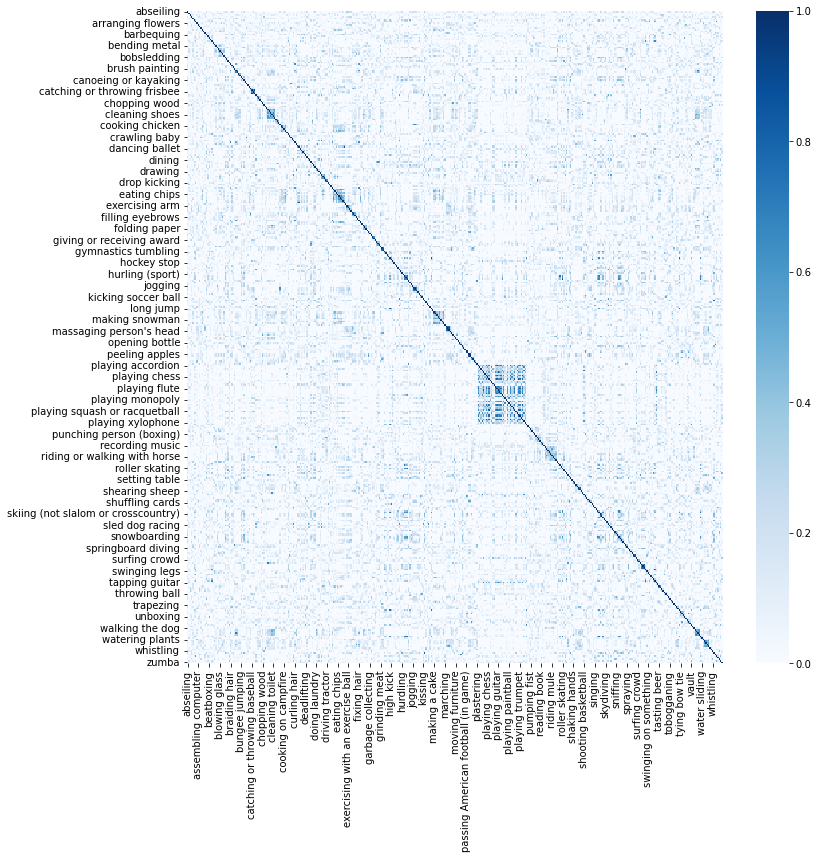

Dataset: UCF


Loading BokehJS ...

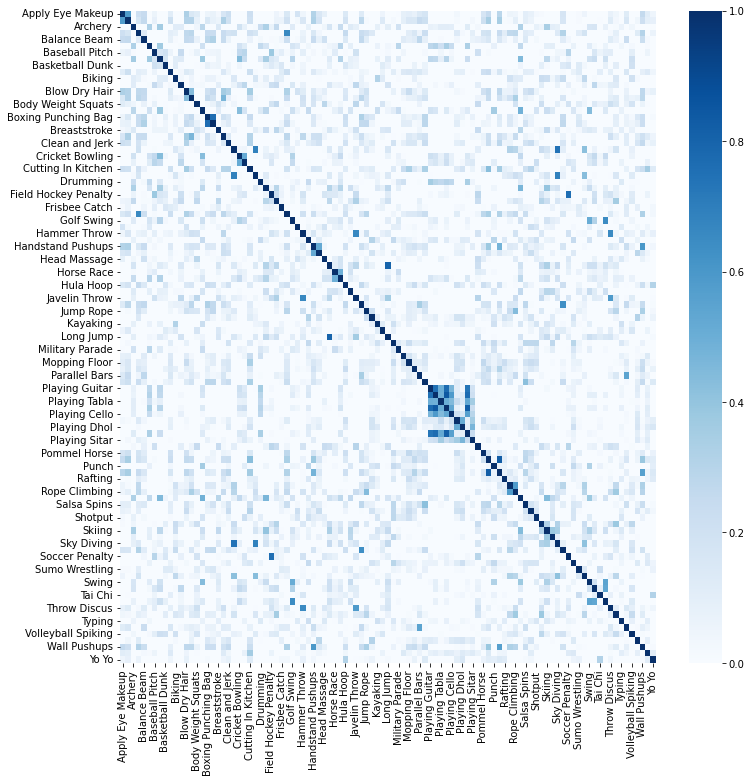

Dataset: NTU


Loading BokehJS ...

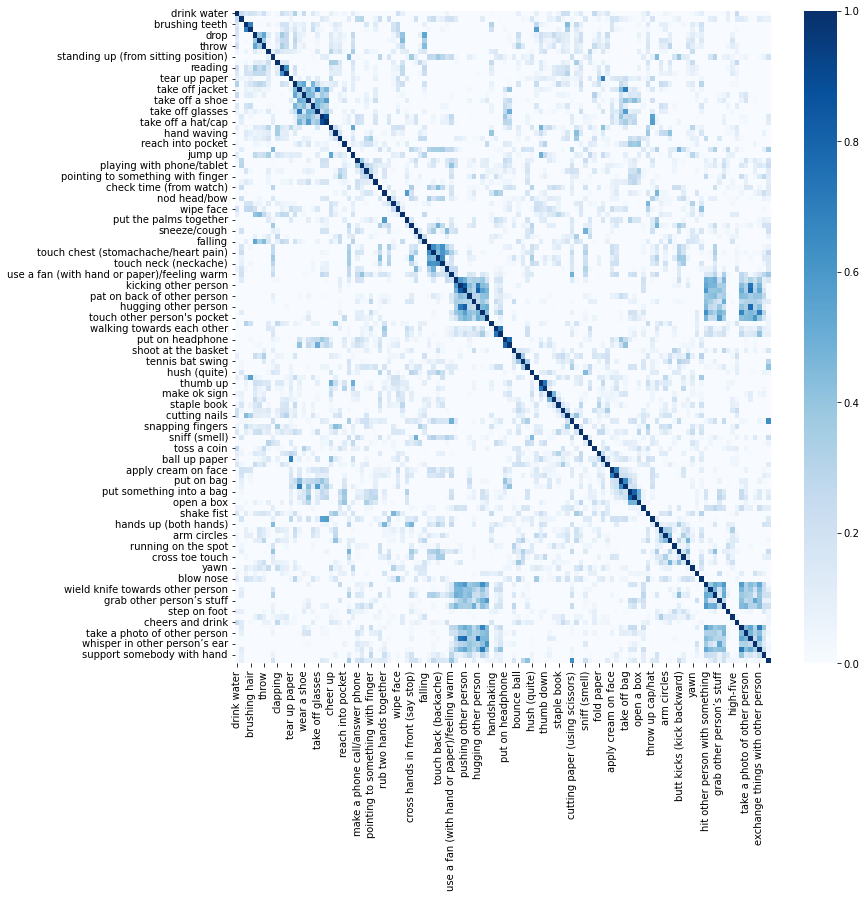

Dataset: SomethingSomething


Loading BokehJS ...

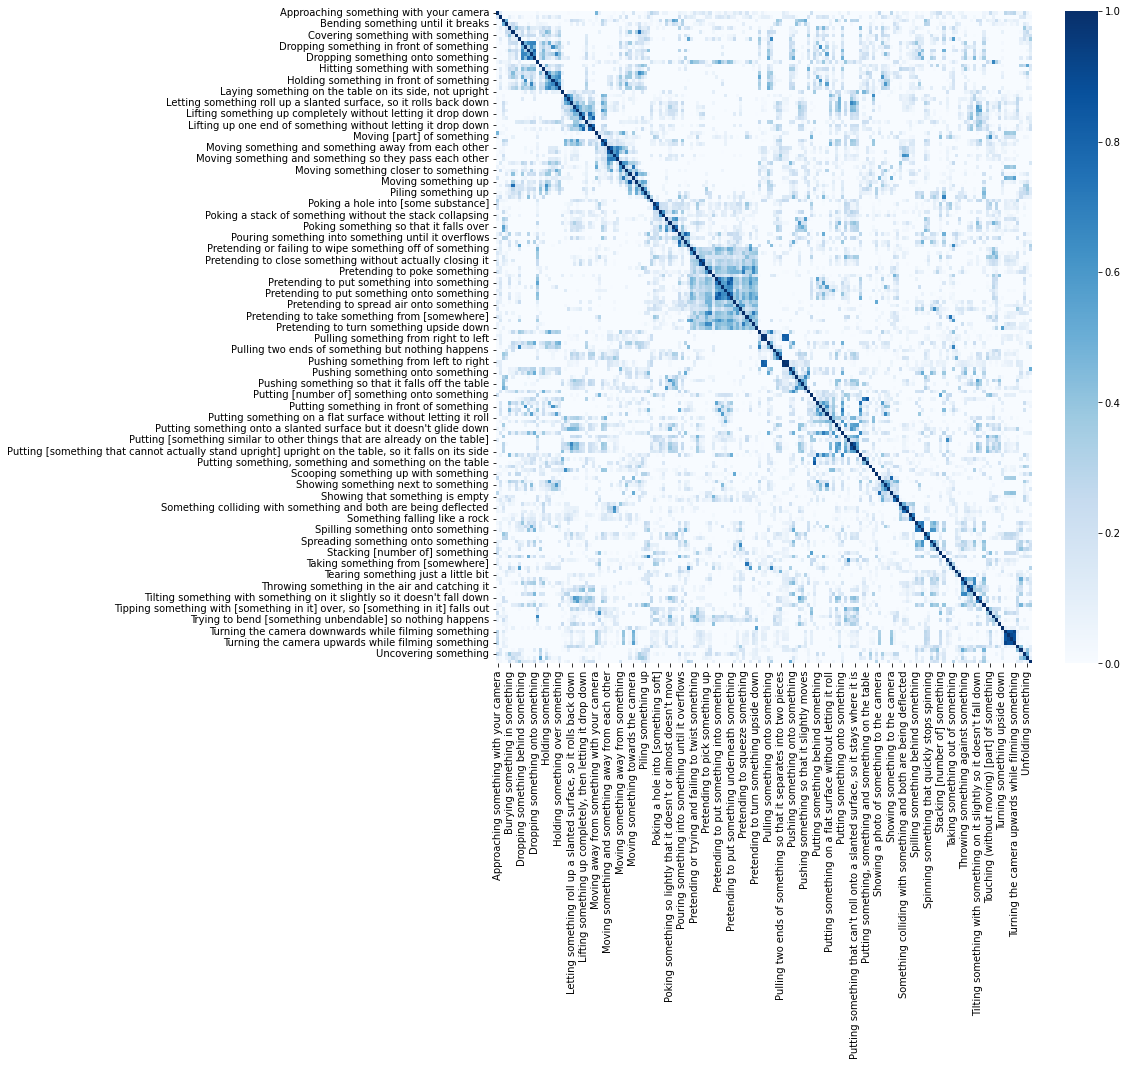

Dataset: FineGym


Loading BokehJS ...

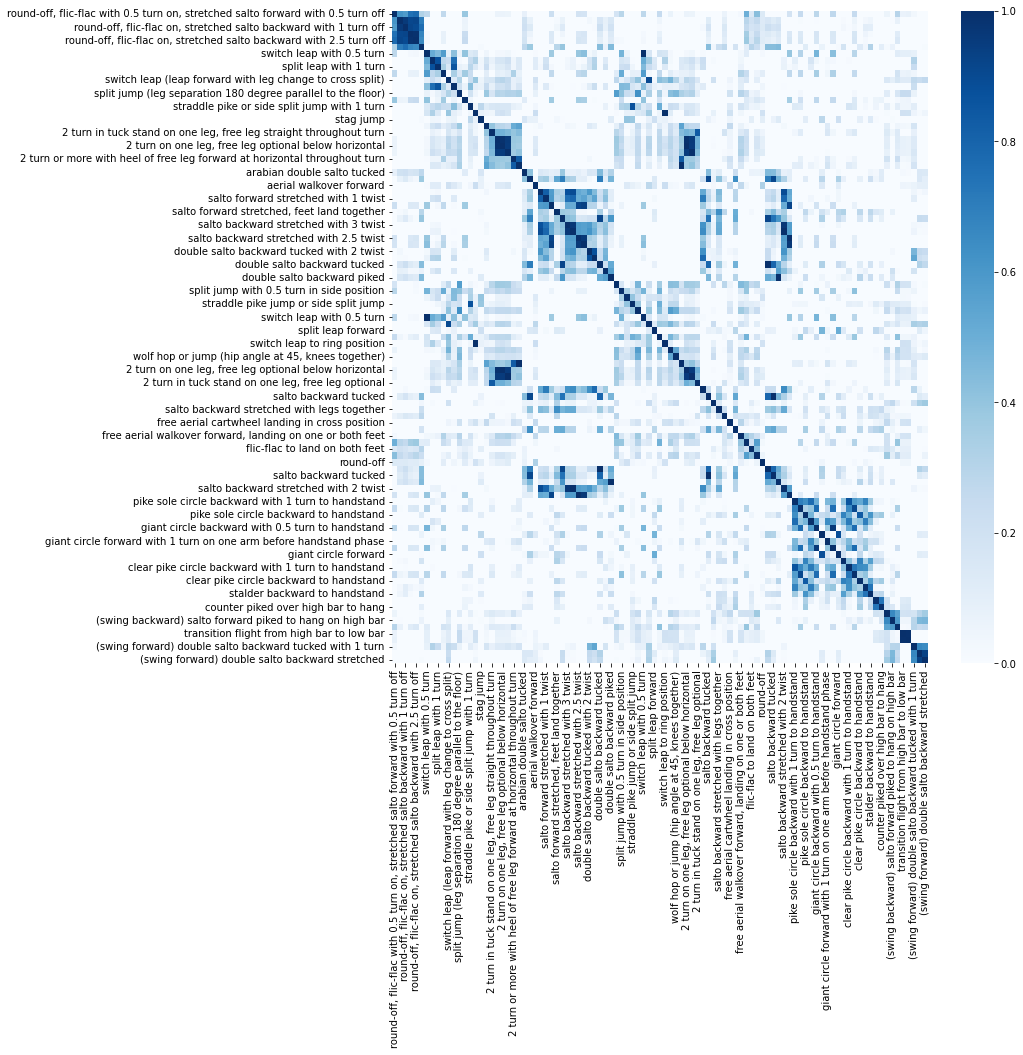

Dataset: EPIC


Loading BokehJS ...

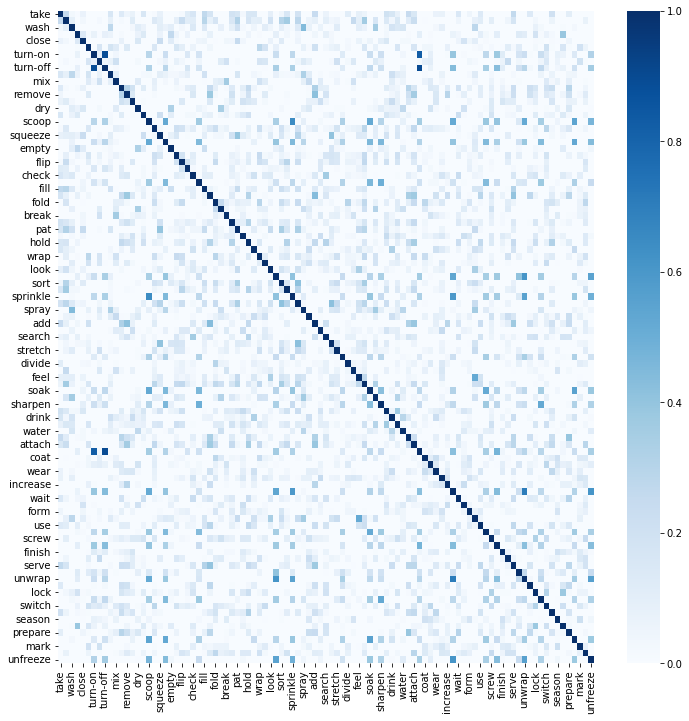

In [72]:
for dataset in dataset_action_embeddings.keys():
    print(f"Dataset: {dataset}")
    
    # plot the embeddings
    idx = [x["name"] for x in datasets].index(dataset)
    color = datasets[idx]["color"]
    plot_dataset_embeddings(dataset, dataset_action_labels[dataset], dataset_action_embeddings[dataset])
    
    # plot the similarity matrix
    heatmap(compute_metric_per_dataset(dataset, subtract_mean=True, normalize=False))

### Compute overlap for every `target` dataset w.r.t. `source` dataset

In [83]:
def compute_label_similarity(source: dict, target: dict, threshold: float = 0.1, subtract_mean=False):
    df = pd.DataFrame(None, index=list(source.keys()), columns=list(target.keys()), dtype=float)

    source_embeddings = torch.stack([v for k, v in source.items()])
    if subtract_mean:
        source_embeddings -= source_embeddings.mean(dim=0)

    target_embeddings = torch.stack([v for k, v in target.items()])
    if subtract_mean:
        target_embeddings -= target_embeddings.mean(dim=0)

    for i in range(len(source_embeddings)):
        df.iloc[i] = F.cosine_similarity(target_embeddings, source_embeddings[[i], :]).numpy()
    
    return df

In [84]:
def compute_label_distance(source: dict, target: dict, threshold: float = 0.1, p=1, subtract_mean=False):
    df = pd.DataFrame(None, index=list(source.keys()), columns=list(target.keys()), dtype=float)

    source_embeddings = torch.stack([v for k, v in source.items()])
    if subtract_mean:
        source_embeddings -= source_embeddings.mean(dim=0)

    target_embeddings = torch.stack([v for k, v in target.items()])
    if subtract_mean:
        target_embeddings -= target_embeddings.mean(dim=0)
    
    for i in range(len(source_embeddings)):
        df.iloc[i] = F.pairwise_distance(target_embeddings, source_embeddings[[i], :], p=p).numpy()
    
    return df

In [85]:
def compute_metric_per_dataset(dataset, metric=compute_label_similarity, subtract_mean=False, normalize=True):
    
    embeddings = dataset_action_embeddings[dataset]
    # if subtract_mean:
    #     embeddings_mean = torch.stack(list(embeddings.values())).mean(dim=0)
    #     embeddings = {k: v - embeddings_mean for k, v in embeddings.items()}

    df = metric(embeddings, embeddings, subtract_mean=subtract_mean)
    df = df.rename(columns=dataset_action_labels[dataset], index=dataset_action_labels[dataset])
    
    
    if normalize:
        df = (df - df.min()) / (df.max() - df.min())
    return df

In [86]:
def compute_metric_between_datasets(
        source, target, metric=compute_label_similarity, subtract_mean=False, normalize=False,
    ):
    
    source_embeddings = dataset_action_embeddings[source]
    target_embeddings = dataset_action_embeddings[target]

    df = metric(source_embeddings, target_embeddings, subtract_mean=subtract_mean)
    df = df.rename(columns=dataset_action_labels[source], index=dataset_action_labels[target])
    
    if normalize:
        df = (df - df.min()) / (df.max() - df.min())

    return df

In [80]:
def heatmap(df, **kwargs):
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    sns.heatmap(df, ax=ax, cmap="Blues", vmin=0.0, vmax=1.0, **kwargs)
    plt.show()

0.0 1.0 0.21274699519875018
0.0 1.0 0.4022249508818287
0.0 1.0 0.3715305857172614
0.0 1.0 0.4619852031850719
0.0 1.0 0.45984769334013115
0.0 1.0 0.41597498546309203


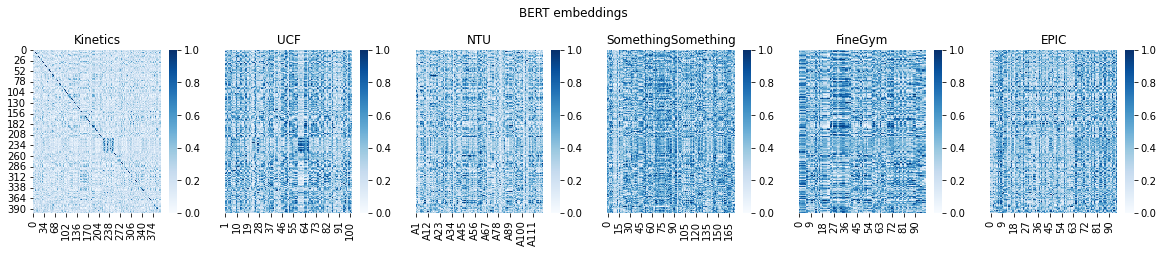

In [88]:
dataset_label_overlap = pd.DataFrame(None, index=["Kinetics"], columns=dataset_action_embeddings.keys())

fig, axes = plt.subplots(1, len(dataset_action_embeddings), figsize=(20, 3))

norm_dfs = dict()

i = 0
for key in dataset_action_embeddings:
    df = compute_label_similarity(
        dataset_action_embeddings["Kinetics"], dataset_action_embeddings[key], subtract_mean=True,
    )
    # df = compute_label_distance(dataset_action_embeddings["Kinetics"], dataset_action_embeddings[key])
    # df = compute_label_similarity(dataset_action_latents["Kinetics"], dataset_action_latents[key])
    # import ipdb; ipdb.set_trace()
    # df.iloc[:, :] = softmax(df.values, axis=0)
    df = (df - df.min()) / (df.max() - df.min())
    # df = 1-df

    overlap = np.linalg.norm(df.values) / df.shape[0]
    # overlap = df.mean().mean()
    print(df.min().min(), df.max().max(), df.mean().mean())
    dataset_label_overlap.loc["Kinetics", key] = overlap

    ax = axes[i]
    sns.heatmap(df, ax=ax, cmap="Blues")
    # ax.set_title(f"{key} ({overlap:.2f})")
    ax.set_title(f"{key}")
    
    if i > 0:
        ax.set_yticks([])
    i += 1
    
    df = df.rename(columns=dataset_action_labels[key], index=dataset_action_labels["Kinetics"])

# plt.suptitle("BERT embeddings (Using Z 2-dim PCA)", y=1.08)
plt.suptitle("BERT embeddings", y=1.08)
plt.show()